In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import ribosomesimulator as r

In [68]:
import numpy as np
import matplotlib.pyplot as plt
def make_matrix(tRNAs, codons, verbose=False):
    # check if tRNAs have 'anticodon' column
    if 'anticodon' not in tRNAs.columns:
        print('tRNA list must contain a column named "anticodon".')
        return
    # check if codons have 'codon' column
    if 'codon' not in codons.columns:
        print('Codon list must contain a column named "codon".')
        return

    def first_WC(codon, tRNA):
        codon_nt = codon[0] # first character
        tRNA_nt = tRNA[2] # third character
        return (codon_nt == "A" and tRNA_nt == "U") or (codon_nt == "C" and tRNA_nt == "G") or \
               (codon_nt == "G" and tRNA_nt == "C") or (codon_nt == "U" and tRNA_nt == "A")

    def second_WC(codon, tRNA):
        codon_nt = codon[1] # second character
        tRNA_nt = tRNA[1] # second character
        return (codon_nt == "A" and tRNA_nt == "U") or (codon_nt == "C" and tRNA_nt == "G") or \
               (codon_nt == "G" and tRNA_nt == "C") or (codon_nt == "U" and tRNA_nt == "A")

    def third_WC(codon, tRNA):
        codon_nt = codon[2] # third character
        tRNA_nt = tRNA[0] # first character
        return (codon_nt == "A" and tRNA_nt in ['U','&','3','1','~','N','S',')','{','V','}','P']) or \
                (codon_nt == "C" and tRNA_nt in ['G','#','W']) or \
                (codon_nt == "G" and tRNA_nt in ['C','B']) or (codon_nt == "U" and tRNA_nt in ['A'])

    def first_wobble(codon, tRNA):
        codon_nt = codon[0] # first character
        tRNA_nt = tRNA[2] # third character
        return (codon_nt == "A" and tRNA_nt in ['A']) or \
                (codon_nt == "C" and tRNA_nt in ['A','U']) or \
                (codon_nt == "G" and tRNA_nt in ['A','U']) or \
                (codon_nt == "U" and tRNA_nt in ['G','U'])

    def third_wobble(codon, tRNA):
        codon_nt = codon[2] # third character
        tRNA_nt = tRNA[0] # first character
        return (codon_nt == "A" and tRNA_nt in ['A','I','M','?']) or \
                (codon_nt == "C" and tRNA_nt in ['A','U','P','I','?']) or \
                (codon_nt == "G" and tRNA_nt in ['A','U','&','3','1','~','N','S',')','{','V','P','Q','?','M']) or \
                (codon_nt == "U" and tRNA_nt in ['G','#','W','U','V','P','I','Q'])

    cognate_WC_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    cognate_wobble_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    nearcognate_matrix = np.zeros((len(tRNAs.anticodon), len(codons.codon)))
    
    if verbose:
        print("Populating WC matrix...")
    # populate cognate WC matrix if WC criteria matched
    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            codon = codons.codon[m]
            anticodon = tRNAs.anticodon[n]
            if second_WC(codon, anticodon) and first_WC(codon, anticodon) and third_WC(codon, anticodon):
                cognate_WC_matrix[n, m] = 1
    if verbose:
        print("done.")
        print("Populating wobble matrix...")
        
    
    #populate cognate wobble matrix if wobble criteria matched, amino acid is correct, and WC matrix entry is 0
    #if incorrect amino acid, assign to near-cognates

    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            if cognate_WC_matrix[n,m] == 0 and second_WC(codons.codon[m],tRNAs.anticodon[n]) and\
            first_WC(codons.codon[m],tRNAs.anticodon[n]) and third_wobble(codons.codon[m],tRNAs.anticodon[n]):
                if tRNAs["three.letter"][n] == codons["three.letter"][m]:
                    cognate_wobble_matrix[n,m] = 1
                else:
                    nearcognate_matrix[n,m] = 1  

    if verbose:
        print('done.')
        print('Populating nearcognate matrix...')

    #populate near-cognate matrix if:
    #wobble and WC matrix entries are 0,
    #wobble criteria are matched

    for n in range(len(tRNAs.anticodon)):
        for m in range(len(codons.codon)):
            if (cognate_WC_matrix[n,m] == 0 and cognate_wobble_matrix[n,m] == 0 and second_WC(codons.codon[m],tRNAs.anticodon[n]) and \
                 (first_wobble(codons.codon[m],tRNAs.anticodon[n]) or first_WC(codons.codon[m],tRNAs.anticodon[n])) and\
                 (third_wobble(codons.codon[m],tRNAs.anticodon[n]) or third_WC(codons.codon[m],tRNAs.anticodon[n])) ):
                nearcognate_matrix[n,m] = 1

    if verbose:
        print('done.')

    #Sanity checks

    #Check whether any tRNA:codon combination is assigned 1 in more than one table (this should not occur)

    testsum = cognate_WC_matrix + cognate_wobble_matrix + nearcognate_matrix
    if np.any(testsum>1):
      print('Warning: multiple relationships for identical tRNA:codon pairs detected.')
      return {}
    elif verbose:
      print('No threesome errors detected.')

    return {"cognate.wc.matrix":cognate_WC_matrix, "cognate.wobble.matrix":cognate_wobble_matrix, "nearcognate.matrix":nearcognate_matrix}


def plot_matrix(matrices_dict, tRNAs, codons,save_fig = None):
    colours=['g', 'y', 'r']
    labels = list(matrices_dict.keys())
    i = 0
    plt.figure(figsize=(25,15))
    plt.grid(True)
    xmax = 0
    for k in matrices_dict.keys():
        c = np.argwhere(matrices_dict[k] == 1)#[:,1]
        # display(c)
        plt.plot(c[:,1], c[:,0], colours[i] + 's', label=labels[i])
        i +=1
    plt.xticks(range(len(codons.codon)), codons.codon, rotation = 45)
    plt.yticks(range(len(tRNAs.anticodon)), tRNAs.anticodon)
    plt.legend()
    if save_fig != None:
        plt.savefig(save_fig)
    plt.show()
    
def make_concentrations(matrices_dict, tRNAs, codons, concentration_col_name = 'gene.copy.number', total_tRNA=190):
    
    WCcognate = matrices_dict["cognate.wc.matrix"]
    wobblecognate = matrices_dict["cognate.wobble.matrix"]
    nearcognate = matrices_dict["nearcognate.matrix"]

    # construct empty results dataframe
    tRNA_concentrations = pd.DataFrame(codons[[codons.columns[0],codons.columns[2]]])
    tRNA_concentrations["WCcognate.conc"] = 0.0
    tRNA_concentrations["wobblecognate.conc"] = 0.0
    tRNA_concentrations["nearcognate.conc"] = 0.0
    
    #calculate a conversion factor to convert the abundance factor to a molar concentration
    print('using: '+ concentration_col_name)
    conversion_factor = np.float64(total_tRNA / np.float64(tRNAs[concentration_col_name].sum()) * 1e-6)
    
    #go through the WCcognates matrix and for each entry of 1 add the abundance of the tRNA from the abundance table to the concentration table
    for n in range(len(codons.codon)):
        for m in range(len(tRNAs.anticodon)):
            if WCcognate[m, n] == 1:
                tRNA_concentrations.loc[n, "WCcognate.conc"] = tRNA_concentrations["WCcognate.conc"][n] + (tRNAs[concentration_col_name][m]*conversion_factor)
    
    #ditto for wobblecognate
    for n in range(len(codons.codon)):
        for m in range(len(tRNAs.anticodon)):
            if wobblecognate[m, n] == 1:
                tRNA_concentrations.loc[n, "wobblecognate.conc"] = tRNA_concentrations["wobblecognate.conc"][n] + (tRNAs[concentration_col_name][m]*conversion_factor)

    #ditto for nearcognates
    for n in range(len(codons.codon)):
        for m in range(len(tRNAs.anticodon)):
            if nearcognate[m, n] == 1:
                tRNA_concentrations.loc[n, "nearcognate.conc"] = tRNA_concentrations["nearcognate.conc"][n] + (tRNAs[concentration_col_name][m]*conversion_factor)
    return tRNA_concentrations

In [69]:
Scer_tRNAs = pd.read_csv('Scer_tRNAs.csv')
codons = pd.read_csv('codons.csv')
Scer_matrix = make_matrix(Scer_tRNAs,codons)

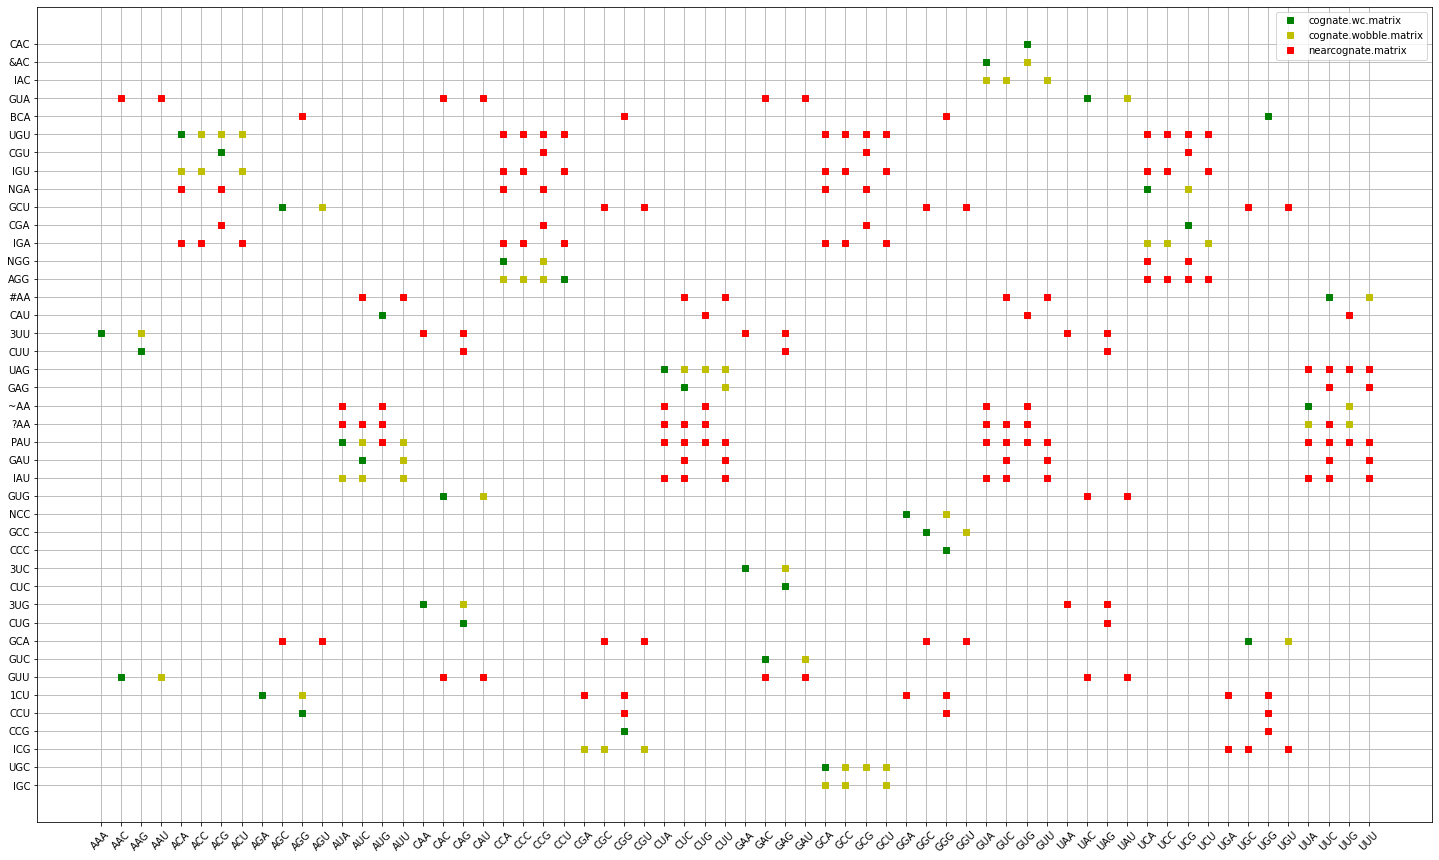

In [70]:
plot_matrix(Scer_matrix,Scer_tRNAs,codons,save_fig = 'Supplemental_figure_matrix.svg')

In [71]:
Scer_concentrations = make_concentrations(Scer_matrix,Scer_tRNAs,codons)
Scer_concentrations.to_csv('Scer_concentrations.csv',index=False)

using: gene.copy.number


In [72]:
#make list of codons
codons = []
nts = ['A','C','G','U']
for nt1 in nts:
    for nt2 in nts:
        for nt3 in nts:
            codon=(nt1+nt2+nt3)
            if codon not in ['UAA','UGA','UAG']:
                codons.append(codon)

In [73]:
#simulate the codons with the new concentrations data
sim = r.ribosomesimulator()
props = sim.getPropensities()
props['wobble6f'] = 6.4
sim.loadConcentrations('Scer_concentrations.csv')
sim.setPropensities(props)
times = []
for codon in codons:
    sim.setCodonForSimulation(codon)
    times.append(sim.run_repeatedly_get_average_time(10000))
decoding_times = pd.DataFrame({'codon':codons,'decoding.time':times})

In [74]:
#compare old and new data
published = pd.read_csv('Scer_published.csv')
decoding_times = published.merge(decoding_times,how='inner',on='codon')

In [78]:
decoding_times.loc[decoding_times['one.letter']=='L']

,codon,three.letter,one.letter,usage.frequency.kazusa,decoding.time.EMBOJ,decoding.time
28,CUA,Leu,L,13.4,0.451,0.651823
29,CUC,Leu,L,5.4,1.411,0.776297
30,CUG,Leu,L,10.5,0.330,0.794094
31,CUU,Leu,L,12.3,0.496,0.677848
57,UUA,Leu,L,26.2,0.187,0.211776
59,UUG,Leu,L,27.2,0.119,0.276518


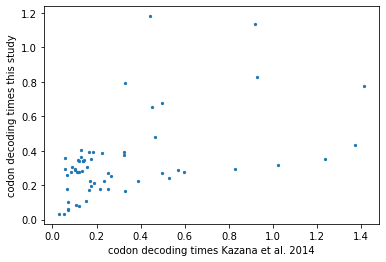

In [80]:
#compare published and revised decoding times
fig,ax = plt.subplots()
ax.scatter(decoding_times['decoding.time.EMBOJ'],decoding_times['decoding.time'],s=5)
ax.set_xlabel('codon decoding times Kazana et al. 2014')
ax.set_ylabel('codon decoding times this study')
plt.savefig('Supplemental_figure_decoding_time_comparison.svg')
plt.show()